In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
import math

# EDA

In [359]:
df1 = pd.read_csv('takehome_user_engagement.csv')
df1.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [360]:
df2 = pd.read_csv('takehome_users.csv', encoding='latin-1')
df2.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [361]:
df1.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [362]:
df2.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [363]:
print(df1.shape)
print(df2.shape)

(207917, 3)
(12000, 10)


In [364]:
# Remove time from date

df1['time_stamp'] = pd.to_datetime(df1['time_stamp'], format='%Y-%m-%d')

## How many adopted users?

In [365]:
def logins_in_days(df, days=7, logins=3):
    # first drop duplicate days and sort by day
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    # calculate how many days has passed for every 3 logins
    passed_days = df['date'].diff(periods=logins-1)
    # check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))

In [366]:
adopted = df1.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'

In [367]:
adopted

user_id
1        False
2         True
3        False
4        False
5        False
         ...  
11996    False
11997    False
11998    False
11999    False
12000    False
Name: adopted_user, Length: 8823, dtype: bool

In [368]:
print('There were {} adopted users out of {} users'.format(sum(adopted), len(adopted)))

There were 1656 adopted users out of 8823 users


Let's look at takehome_users dataframe.

In [369]:
df2.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [370]:
df2.shape

(12000, 10)

In [371]:
# We are dropping any unecessary data, org_id is dropped because of too many null values

df2 = df2.drop(['name', 'email', 'org_id'], axis=1)
df2.dtypes

object_id                       int64
creation_time                  object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
invited_by_user_id            float64
dtype: object

In [372]:
df2['creation_time'] = pd.to_datetime(df2['creation_time'], format='%Y-%m-%d %H:%M:%S')
df2['last_session_creation_time'] = pd.to_datetime(df2['last_session_creation_time'], unit='s')
df2.dtypes

object_id                              int64
creation_time                 datetime64[ns]
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
invited_by_user_id                   float64
dtype: object

In [373]:
# Dropping any unecessary columns

df2['history'] = df2['last_session_creation_time'].sub(df2['creation_time'], axis=0)
df2 = df2.drop(['creation_time', 'last_session_creation_time', 'invited_by_user_id'], axis=1)
df2 = df2.rename({'object_id':'user_id'}, axis=1)

In [374]:
df2.head()

,user_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history
0,1,GUEST_INVITE,1,0,0 days
1,2,ORG_INVITE,0,0,136 days
2,3,ORG_INVITE,0,0,0 days
3,4,GUEST_INVITE,0,0,1 days
4,5,GUEST_INVITE,0,0,5 days


In [375]:
user = adopted.to_frame().merge(df2, on = 'user_id', how = 'inner')
user.head()

,user_id,adopted_user,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history
0,1,False,GUEST_INVITE,1,0,0 days
1,2,True,ORG_INVITE,0,0,136 days
2,3,False,ORG_INVITE,0,0,0 days
3,4,False,GUEST_INVITE,0,0,1 days
4,5,False,GUEST_INVITE,0,0,5 days


In [376]:
user.dtypes

user_id                                 int64
adopted_user                             bool
creation_source                        object
opted_in_to_mailing_list                int64
enabled_for_marketing_drip              int64
history                       timedelta64[ns]
dtype: object

In [377]:
user['history'] = user['history'].dt.days
user['history'] = user['history'].astype(float)

In [378]:
user['adopted_user'] = user['adopted_user'].astype(int)
user.dtypes

user_id                         int64
adopted_user                    int32
creation_source                object
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
history                       float64
dtype: object

In [379]:
user.corr()

,user_id,adopted_user,opted_in_to_mailing_list,enabled_for_marketing_drip,history
user_id,1.000000,0.003676,-0.034920,-0.028916,-0.008526
adopted_user,0.003676,1.000000,0.007485,0.004290,0.777844
opted_in_to_mailing_list,-0.034920,0.007485,1.000000,0.488219,0.005609
enabled_for_marketing_drip,-0.028916,0.004290,0.488219,1.000000,0.007417
history,-0.008526,0.777844,0.005609,0.007417,1.000000


<AxesSubplot:>

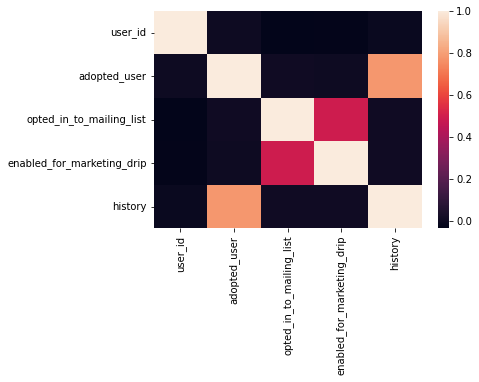

In [380]:
sns.heatmap(user.corr())

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'GUEST_INVITE'),
  Text(1, 0, 'ORG_INVITE'),
  Text(2, 0, 'SIGNUP'),
  Text(3, 0, 'PERSONAL_PROJECTS'),
  Text(4, 0, 'SIGNUP_GOOGLE_AUTH')])

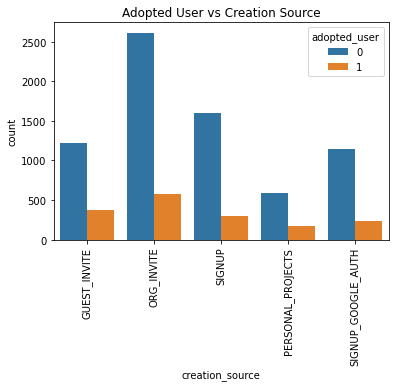

In [381]:
# Let's graph the only categorical data in our user dataframe

sns.countplot(x='creation_source', data=user, hue='adopted_user') 
plt.title('Adopted User vs Creation Source')
plt.xticks(rotation=90)

In [382]:
users = pd.get_dummies(user)
users.head()

,user_id,adopted_user,opted_in_to_mailing_list,enabled_for_marketing_drip,history,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,1,0,0.0,1,0,0,0,0
1,2,1,0,0,136.0,0,1,0,0,0
2,3,0,0,0,0.0,0,1,0,0,0
3,4,0,0,0,1.0,1,0,0,0,0
4,5,0,0,0,5.0,1,0,0,0,0


In [383]:
users.isnull().sum()

user_id                               0
adopted_user                          0
opted_in_to_mailing_list              0
enabled_for_marketing_drip            0
history                               0
creation_source_GUEST_INVITE          0
creation_source_ORG_INVITE            0
creation_source_PERSONAL_PROJECTS     0
creation_source_SIGNUP                0
creation_source_SIGNUP_GOOGLE_AUTH    0
dtype: int64

# Modeling and Prediction

In [384]:
X = users.drop(['adopted_user'], axis = 1)
y = users['adopted_user']

In [385]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [387]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [393]:
from sklearn.metrics import classification_report, accuracy_score

print('Accuracy of test set was', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy of test set was 0.9580736543909348
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1417
           1       0.92      0.87      0.89       348

    accuracy                           0.96      1765
   macro avg       0.94      0.92      0.93      1765
weighted avg       0.96      0.96      0.96      1765



In [394]:
df_importance = pd.DataFrame(zip(list(X.columns),rf.feature_importances_),index=range(X.columns.shape[0]),columns=['feature','importance'])
df_importance.sort_values(by='importance',ascending=False)

,feature,importance
3,history,0.886496
0,user_id,0.093253
1,opted_in_to_mailing_list,0.004379
2,enabled_for_marketing_drip,0.003403
4,creation_source_GUEST_INVITE,0.002983
5,creation_source_ORG_INVITE,0.002776
7,creation_source_SIGNUP,0.002408
8,creation_source_SIGNUP_GOOGLE_AUTH,0.002241
6,creation_source_PERSONAL_PROJECTS,0.002061
